CIFAR10 dataset trained on all classes with 'normal' CNN without augmentation. Highest accuracy 80 %

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "MODEL": 'cnn',
    "DS_INFO": 'complete',
    "resample": False,
    "neg_class": ['ship'],
    "NUM_EPOCHS": 100,
    "BATCH_SIZE": 64,
    "IMG_SIZE": (32, 32, 3),
    "outcast": None,
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["NUM_EPOCHS"], config["BATCH_SIZE"], 
                                     config["IMG_SIZE"][1], config["DS_INFO"], config["MODEL"])

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Directories:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']

cat               : 5000
airplane          : 5000
deer              : 5000
automobile        : 5000
ship              : 5000
horse             : 5000
truck             : 5000
dog               : 5000
bird              : 5000
frog              : 5000

Total number of images: 50000, in 10 classes
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[3 8 2 4 2 3 3 3 1 7]
[7 9 3 1 9 6 9 4 5 2]
[5 0 7 8 8 6 5 7 2 2]
[4 1 0 2 4 7 1 3 3 0]
[9 0 3 9 6 3 5 6 2 3]
[4 7 1 9 3 1 7 0 6 9]
[4 4 3 8 2 6 7 1 2 1]
[9 5 2 9 6 0 3 7 0 2]
[5 3 2 2 5 0 8 1 9 5]
[1 2 6 0 9 2 1 2 8 2]


## Training
### Normal CNN
See: https://www.tensorflow.org/tutorials/images/cnn  
learningRateScheduler: https://github.com/lambdal/TensorFlow2-tutorial/tree/master/01-basic-image-classification  
model from: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/  

In [4]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler

Using TensorFlow backend.


Create the model

In [5]:
cnn_model = models.Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=config["IMG_SIZE"]))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.4))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(params["NUM_CLASSES"], activation='softmax'))

In [6]:
if config["verbosity"] > 0:
    cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        1

In [7]:
BASE_LEARNING_RATE = 0.1
LR_SCHEDULE = [(0.1, 15), (0.01, 90)]

def schedule(epoch):
    initial_learning_rate = BASE_LEARNING_RATE
    learning_rate = initial_learning_rate
    for mult, start_epoch in LR_SCHEDULE:
        if epoch >= start_epoch:
            learning_rate = initial_learning_rate * mult
        else:
            break
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

Compile and train the model

In [8]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

cnn_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir='./logs/tensorboard/{}'.format(model_name), update_freq='batch')
callbacks = [tensorboard_cb, LearningRateScheduler(schedule)]

In [9]:
history = cnn_model.fit(
        train_ds,
        steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
        epochs = config["NUM_EPOCHS"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // config["BATCH_SIZE"],
        validation_freq = 1,
        callbacks = callbacks)

Train for 546 steps, validate for 117 steps
Epoch 1/100
546/546 [==============================] - 6s 11ms/step - loss: 2.0154 - accuracy: 0.2670 - val_loss: 1.7068 - val_accuracy: 0.3614
Epoch 2/100
546/546 [==============================] - 4s 7ms/step - loss: 1.6772 - accuracy: 0.3821 - val_loss: 1.7889 - val_accuracy: 0.3339
Epoch 3/100
546/546 [==============================] - 4s 8ms/step - loss: 1.5049 - accuracy: 0.4560 - val_loss: 1.5318 - val_accuracy: 0.4901
Epoch 4/100
546/546 [==============================] - 4s 8ms/step - loss: 1.3841 - accuracy: 0.5182 - val_loss: 1.1748 - val_accuracy: 0.5865
Epoch 5/100
546/546 [==============================] - 4s 8ms/step - loss: 1.2824 - accuracy: 0.5584 - val_loss: 1.1531 - val_accuracy: 0.5991
Epoch 6/100
546/546 [==============================] - 4s 7ms/step - loss: 1.2273 - accuracy: 0.5789 - val_loss: 1.3088 - val_accuracy: 0.5593
Epoch 7/100
546/546 [==============================] - 4s 8ms/step - loss: 1.1597 - accuracy: 0.6

In [10]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [11]:
cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

117/117 - 0s - loss: 0.2868 - accuracy: 0.9127


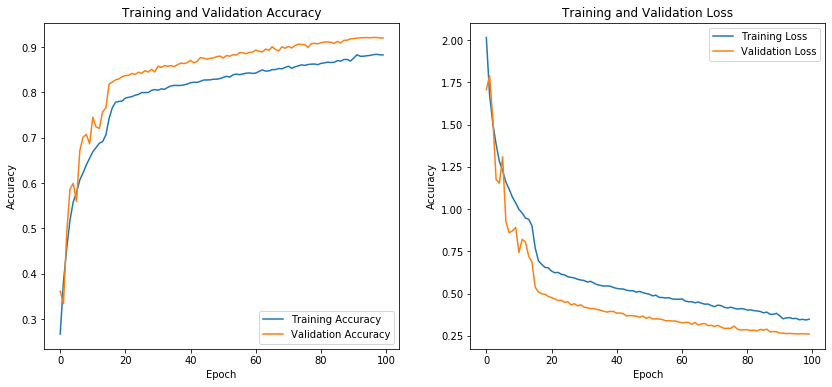

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config["NUM_EPOCHS"])

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [13]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 cat
0.0000 airplane
0.0000 deer
0.0002 automobile
0.0000 ship
0.0000 horse
0.9997 truck
0.0000 dog
0.0000 bird
0.0000 frog

Label: truck
Predicton: truck


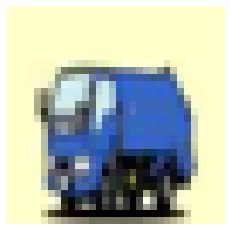

In [25]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [15]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:10}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -------     --------')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:10}  {:10}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label       pred
---  -------     --------

  0  horse       horse     
  1  airplane    airplane  
  2  airplane    airplane  
  3  airplane    airplane  
  4  dog         dog       
  5  deer        deer      
  6  horse       horse     
  7  horse       horse     
  8  truck       truck     
  9  ship        ship      
 10  airplane    airplane  
 11  automobile  automobile
 12  automobile  automobile
 13  cat         cat       
 14  cat         cat       
 15  bird        bird      
 16  ship        ship      
 17  cat         cat       
 18  dog         dog       
 19  ship        ship      
 20  dog         dog       
 21  automobile  automobile
 22  frog        frog      
 23  bird        deer        Wrong
 24  frog        frog      
 25  airplane    airplane  
 26  dog         dog       
 27  ship        ship      
 28  horse       horse     
 29  bird        bird      
 30  dog         cat         Wrong
 31  frog        frog      
 32  ship        ship      
 33  ship    